<a href="https://colab.research.google.com/github/dnguyend/SimpleFlag/blob/main/colab/SimpleFlag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization examples on flag manifolds

First, loading the required libraries

In [2]:
!git clone  https://github.com/pymanopt/pymanopt.git
import sys
sys.path.append("/content/pymanopt")

Cloning into 'pymanopt'...
remote: Enumerating objects: 4127, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4127 (delta 0), reused 0 (delta 0), pack-reused 4124
Receiving objects: 100% (4127/4127), 899.14 KiB | 12.15 MiB/s, done.
Resolving deltas: 100% (2876/2876), done.


In [3]:
!git clone https://github.com/dnguyend/ManNullRange.git
!git clone https://github.com/dnguyend/SimpleFlag.git

Cloning into 'ManNullRange'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 253 (delta 164), reused 106 (delta 60), pack-reused 0
Receiving objects: 100% (253/253), 770.12 KiB | 5.97 MiB/s, done.
Resolving deltas: 100% (164/164), done.
Cloning into 'SimpleFlag'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 6), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [4]:
sys.path.append("/content/ManNullRange")
sys.path.append("/content/SimpleFlag")


In [5]:
from SimpleFlag.manifolds import RealFlagOpt


Simple code, test Trust region and Steepest descent, then run over a ladder of 60 grid points of $\alpha = \alpha_1/\alpha_0$ from $0.12$ to $1.28$.

In [5]:
import numpy as np
from numpy import trace
from SimpleFlag.manifolds.RealFlagOpt import RealFlagOpt


def l1(A):
    return np.max(np.abs(A))

if True:
    from ManNullRange.tests.test_tools import random_orthogonal
    
    from pymanopt import Problem
    from pymanopt.solvers import TrustRegions
    from pymanopt.function import Callable

    n = 1000
    np.random.seed(0)
    
    for i in range(1):
        dvec = np.array([0, 30, 20, 10])
        # dvec = np.array([0, 3, 2, 2])
        dvec[0] = n - dvec[1:].sum()
        
        d = dvec[1:].sum()
        dvec[0] = n - d
        D = np.random.randint(1, 100, n) * 0.2
        OO = random_orthogonal(n)
        A = OO @ np.diag(D) @ OO.T

        alp = np.array([1, np.random.randint(1, 20)*.1])
        man = RealFlagOpt(dvec, alp=alp)
        pp = dvec.shape[0] - 1
        
        Lbd = np.concatenate(
            [dvec[a]*[a] for a in np.arange(1, pp+1)])        
        
        @Callable
        def cost(X):
            U = ((X.T@A)@X)*Lbd[None, :]
            return trace(U@U)
        
        @Callable
        def egrad(X):
            AXL = (A@X)*Lbd[None, :]
            return 4*AXL@(X.T@AXL)

        @Callable
        def ehess(X, H):
            AHL = (A@H)*Lbd[None, :]
            AXL = (A@X)*Lbd[None, :]
            return 4*AHL@(X.T@AXL) + 4*AXL@(H.T@AXL) + 4*AXL@(X.T@AHL)
                
        if False:
            X = man.rand()
            xi = man.randvec(X)
            d1 = num_deriv(man, X, xi, cost)
            d2 = trace(egrad(X) @ xi.T)
            print(l1(d1-d2))

            # test retraction.
            dlt = 1e-7
            print((man.exp(X, dlt*xi) - X)/dlt-xi)
            print(l1(ehess(X, xi) - (egrad(X+dlt*xi) - egrad(X))/dlt))
                    
        # prob = Problem(man, cost, egrad=egrad)
        XInit = man.rand()

        print('doing alp %s' % alp)
        prob = Problem(
            man, cost, egrad=egrad, ehess=ehess, verbosity=1)

        solver = TrustRegions(maxtime=100000, maxiter=100)
        opt = solver.solve(prob, x=XInit, Delta_bar=250)

        from pymanopt.solvers import SteepestDescent
        prob = Problem(man, cost=cost, egrad=egrad, verbosity=1)
        solvS = SteepestDescent(
            maxtime=10000, maxiter=1000000, mingradnorm=1e-8)

        print('Doing SteepestDescent')
        opt2 = solvS.solve(prob, x=XInit)

        for alx in range(1, 60):
            alpha_c = alp.copy()
            alpha_c[1] = .1 + alx*.02
            man1 = RealFlagOpt(dvec, alp=alpha_c)
            prob = Problem(man1, cost, egrad=egrad, ehess=ehess, verbosity=1)

            solver = TrustRegions(maxtime=100000, maxiter=100)
            opt = solver.solve(prob, x=XInit, Delta_bar=250)
            print('alp =%s cost =%f' % (alpha_c, cost(opt)))                        
            
        


doing alp [1.  0.4]
Optimizing...
Terminated - min grad norm reached after 16 iterations, 6.20 seconds.

Doing SteepestDescent
Terminated - min stepsize reached after 1240 iterations, 34.95 seconds.

Optimizing...
Terminated - min grad norm reached after 25 iterations, 6.38 seconds.

alp =[1.   0.12] cost =40.120000
Optimizing...
Terminated - min grad norm reached after 23 iterations, 7.59 seconds.

alp =[1.   0.14] cost =40.120000
Optimizing...
Terminated - min grad norm reached after 20 iterations, 7.48 seconds.

alp =[1.   0.16] cost =40.120000
Optimizing...
Terminated - min grad norm reached after 19 iterations, 6.47 seconds.

alp =[1.   0.18] cost =40.120000
Optimizing...
Terminated - min grad norm reached after 17 iterations, 5.56 seconds.

alp =[1.  0.2] cost =40.120000
Optimizing...
Terminated - min grad norm reached after 18 iterations, 6.61 seconds.

alp =[1.   0.22] cost =40.120000
Optimizing...
Terminated - min grad norm reached after 18 iterations, 6.76 seconds.

alp =[1. 

Parse the output and collect the data to a table of $\alpha$, number of iterations and time in seconds. There is no noticable pattern in time, but number of iterations seems to be high at small $\alpha$.

In [6]:
with open('/content/SimpleFlag/tests/test_res.txt') as fi:
    lns = fi.readlines()
hret = {}
cnt = 0

def parse_line(alist):
    save_item = []
    for a in alist:
        try:
            save_item.append(float(a))
        except Exception as e:
            pass
    return save_item

for i in range(len(lns)):
    if lns[i].startswith('Terminated'):
        save_item = parse_line(lns[i].split())
    elif lns[i].startswith('alp'):
        hret[cnt] = {'al': float(lns[i].split()[2][:-1]),
                    'items': save_item}
        cnt += 1
lnr = len(hret)
ret = np.zeros((lnr, 3))
for i in sorted(hret):
    ret[i, 0] = hret[i]['al']
    ret[i, 1] = hret[i]['items'][0]
    ret[i, 2] = hret[i]['items'][1]
print(ret)

[[ 0.12 25.    8.8 ]
 [ 0.14 23.   10.36]
 [ 0.16 20.   10.23]
 [ 0.18 19.    8.95]
 [ 0.2  17.    7.74]
 [ 0.22 18.    9.09]
 [ 0.24 18.    9.33]
 [ 0.26 19.    9.67]
 [ 0.28 19.   11.41]
 [ 0.3  19.    9.55]
 [ 0.32 19.   10.43]
 [ 0.34 17.    8.99]
 [ 0.36 16.    8.8 ]
 [ 0.38 16.    9.33]
 [ 0.4  16.    8.42]
 [ 0.42 17.   12.21]
 [ 0.44 16.    9.57]
 [ 0.46 15.    9.03]
 [ 0.48 15.   10.64]
 [ 0.5  14.    8.42]
 [ 0.52 15.   10.01]
 [ 0.54 14.    7.9 ]
 [ 0.56 14.    8.08]
 [ 0.58 14.    8.03]
 [ 0.6  15.    8.92]
 [ 0.62 15.    9.92]
 [ 0.64 15.   10.58]
 [ 0.66 15.   10.62]
 [ 0.68 15.   10.78]
 [ 0.7  14.    7.54]
 [ 0.72 15.   11.02]
 [ 0.74 15.   10.42]
 [ 0.76 15.   11.1 ]
 [ 0.78 14.    8.01]
 [ 0.8  16.   10.29]
 [ 0.82 16.   10.77]
 [ 0.84 16.   11.38]
 [ 0.86 16.   11.72]
 [ 0.88 16.   11.9 ]
 [ 0.9  17.   13.74]
 [ 0.92 17.   13.64]
 [ 0.94 16.   11.17]
 [ 0.96 16.   10.76]
 [ 0.98 15.    9.31]
 [ 1.   16.   12.  ]
 [ 1.02 15.   10.71]
 [ 1.04 15.   10.45]
 [ 1.06 15.  

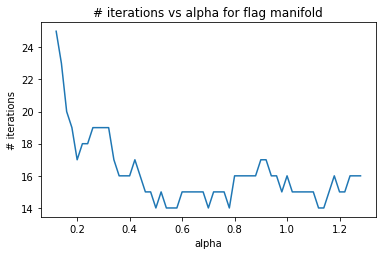

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(111)
ax1.set_ylabel('# iterations')
ax1.set_xlabel('alpha')
ax1.set_title('# iterations vs alpha for flag manifold')
plt.plot(ret[:, 0], ret[:, 1])

# Run one separate simulation to show superlinear convergence

In [ ]:
import numpy as np
from numpy import trace
from SimpleFlag.manifolds.RealFlagOpt import RealFlagOpt

from ManNullRange.tests.test_tools import random_orthogonal

from pymanopt import Problem
from pymanopt.solvers import TrustRegions
from pymanopt.function import Callable


def l1(A):
    return np.max(np.abs(A))


n = 1000
np.random.seed(0)


dvec = np.array([0, 30, 20, 10])

dvec[0] = n - dvec[1:].sum()

d = dvec[1:].sum()
dvec[0] = n - d
D = np.random.randint(1, 100, n) * 0.2
OO = random_orthogonal(n)
A = OO @ np.diag(D) @ OO.T

alp = np.array([1, np.random.randint(1, 20)*.1])
man = RealFlagOpt(dvec, alp=alp)
pp = dvec.shape[0] - 1

Lbd = np.concatenate(
    [dvec[a]*[a] for a in np.arange(1, pp+1)])        

@Callable
def cost(X):
    U = ((X.T@A)@X)*Lbd[None, :]
    return trace(U@U)

@Callable
def egrad(X):
    AXL = (A@X)*Lbd[None, :]
    return 4*AXL@(X.T@AXL)

@Callable
def ehess(X, H):
    AHL = (A@H)*Lbd[None, :]
    AXL = (A@X)*Lbd[None, :]
    return 4*AHL@(X.T@AXL) + 4*AXL@(H.T@AXL) + 4*AXL@(X.T@AHL)
        
XInit = man.rand()

alp = np.array([1, 1.])
man = RealFlagOpt(dvec, alp=alp)
prob = Problem(
    man, cost, egrad=egrad, ehess=ehess, verbosity=2)

solver = TrustRegions(maxtime=100000, maxiter=100)
opt = solver.solve(prob, x=XInit, Delta_bar=250)


Optimizing...
                                            f: +1.985264e+04   |grad|: 7.623233e+03
REJ TR-   k:     1     num_inner:     1     f: +1.985264e+04   |grad|: 7.623233e+03   negative curvature
acc       k:     2     num_inner:     1     f: +3.265756e+03   |grad|: 1.419827e+03   negative curvature
acc       k:     3     num_inner:     3     f: +6.790686e+02   |grad|: 8.642621e+02   negative curvature
acc       k:     4     num_inner:     6     f: +2.932108e+02   |grad|: 3.878877e+02   exceeded trust region
acc       k:     5     num_inner:    10     f: +1.754229e+02   |grad|: 2.276902e+02   negative curvature
acc       k:     6     num_inner:    12     f: +1.181011e+02   |grad|: 1.359193e+02   negative curvature
acc       k:     7     num_inner:    14     f: +8.380086e+01   |grad|: 7.562125e+01   exceeded trust region
acc       k:     8     num_inner:    14     f: +6.749491e+01   |grad|: 5.320430e+01   exceeded trust region
acc TR-   k:     9     num_inner:    16     f: +6.076

Collect the data and graph


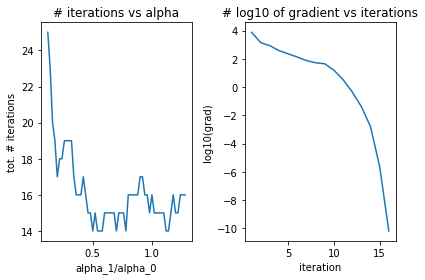

In [ ]:
ret2 = np.array([[1,  +1.985264e+04, 7.623233e+03],
[2,  +3.265756e+03,    1.419827e+03],
[3,  +6.790686e+02, 8.642621e+02],
[4,   +2.932108e+02, 3.878877e+02],
[5, +1.754229e+02, 2.276902e+02],
[6, +1.181011e+02, 1.359193e+02],
[7, +8.380086e+01, 7.562125e+01],
[8, +6.749491e+01, 5.320430e+01],
[9, +6.076605e+01, 4.502733e+01],   
[10, +4.247978e+01, 1.575904e+01],
[11, +4.031294e+01, 3.398976e+00],
[12, +4.012651e+01, 4.548822e-01],
[13, +4.012007e+01, 4.175538e-02],
[14, +4.012000e+01, 1.565215e-03],
[15,+4.012000e+01,  2.323335e-06],
[16, +4.012000e+01, 6.503578e-11]])
# Terminated - min grad norm reached after 16 iterations, 12.41 seconds.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(top=.8)
# fig.suptitle('Optimzation on flag manifolds')
ax1.set_ylabel('tot. # iterations')
ax1.set_xlabel('alpha_1/alpha_0')
ax1.set_title('# iterations vs alpha')
ax1.plot(ret[:, 0], ret[:, 1])

ax2.set_ylabel('log10(grad)')
ax2.set_xlabel('iteration')
ax2.set_title('# log10 of gradient vs iterations')
ax2.plot(ret2[:, 0], np.log10(ret2[:, 2]))
fig.tight_layout()

In [6]:
import numpy as np
from numpy import trace
from SimpleFlag.manifolds.RealFlagOpt import RealFlagOpt


def l1(A):
    return np.max(np.abs(A))

Check various properties: projection is horizontal (man.J = 0), inverse works

In [7]:
dvec = np.array([4, 3, 2])
alp = np.array([1, .8])
man = RealFlagOpt(dvec, alp)

Y = man.rand()
omg = man._rand_ambient()
xi = man.randvec(Y)
print(man.J(Y, xi))
print(man.J(Y, man.proj(Y, omg)))

print(l1(omg - man.g(Y, man.g_inv(Y, omg))))

s1 = man.proj_g_inv(Y, omg)
s2 = man.proj(Y, man.g_inv(Y, omg))
print(l1(s1 - s2))
print((man.inner(Y, omg, xi) - man.inner(Y, man.proj(Y, omg), xi)))

eta = man.randvec(Y)    



{(2, 2): array([[ 7.97787281e-17, -1.57984895e-17],
       [-1.32527645e-17, -1.36955014e-17]]), (1, 2): array([[ 0.00000000e+00,  8.32667268e-17],
       [ 1.66533454e-16, -4.16333634e-17],
       [-2.77555756e-17,  6.93889390e-17]]), (1, 1): array([[-3.01600004e-17, -6.57909356e-18,  1.05037612e-17],
       [-1.15069272e-16,  7.36129780e-17, -1.59377507e-16],
       [ 5.09990764e-17,  2.33499477e-18,  7.91147668e-17]])}
{(2, 2): array([[-2.33360036e-16,  2.97175240e-16],
       [-1.94153752e-16, -2.00399290e-16]]), (1, 2): array([[-3.74700271e-16, -1.66533454e-16],
       [-4.16333634e-17,  5.55111512e-17],
       [ 5.55111512e-17, -1.11022302e-16]]), (1, 1): array([[-1.39582543e-16,  3.77072555e-18,  2.87584709e-17],
       [-5.37465173e-16, -7.76155663e-16,  6.99247168e-16],
       [ 2.41829421e-16,  1.88935793e-16, -3.30172088e-16]])}
2.220446049250313e-16
3.3306690738754696e-16
-1.3877787807814457e-16
2.7755575615628914e-17


In [15]:
n = dvec.sum()
p = dvec[1:].sum()

egrad = np.random.randn(n, p)
ehess = np.random.randn(n, p)

s2 = man.ehess2rhess(Y, egrad, ehess, xi)
print('Check Riemannian Hessian vector and bilinear comforms')
print(man.rhess02(Y, xi, eta, egrad, ehess))
print(man.inner(Y, s2, eta))

print('Check flag_sym is self adjoint')
print(np.trace(egrad.T@Y@man.flag_sym(xi.T@eta)))
print(np.trace((xi.T@eta).T@man.flag_sym(Y.T@egrad)))

# Check compatible with metric
def eta_func(X):
  return man.proj(X, eta)

dlt = 1e-8
ehess1 = man.D_proj(Y, xi, eta)
Yxi = Y+dlt*xi
print(l1((eta_func(Yxi) - eta_func(Y))/dlt - ehess1))
covar = ehess1 + man.GammaH(Y, xi, eta)
print('Check compatibility with metric: the following 2 expressions should be the same')
print((man.inner(Yxi, eta_func(Yxi), eta_func(Yxi)) - man.inner(Y, eta_func(Y), eta_func(Y)))/dlt)
print(2*man.inner(Y, covar, eta_func(Y)))

print('Check torsion free: projection of diff is zero')
print(l1(man.proj(Y, man.GammaH(Y, xi, eta) -
                  man.GammaH(Y, eta, xi))))


Check Riemannian Hessian vector and bilinear comforms
-0.9996267761691127
-0.9996267761691129
Check flag_sym is self adjoint
0.05472467852508359
0.054724678525083614
4.594703457982963e-09
Check compatibility with metric: the following 2 expressions should be the same
-0.01400267679585454
-0.014002677580971335
Check torsion free: projection of diff is zero
2.7755575615628914e-17
